In [75]:
%matplotlib inline
import os
import sys

import glob
import pylab
import pandas as pd
import pydicom
import numpy as np

from PIL import Image

# '../../src/dcm_wrangler.py'
sys.path.insert(1, '../../src/')
import dcm_wrangler as kgtools

kaggle_data_dir = '../../data/all'
train_data_dir = os.path.join(kaggle_data_dir, 'stage_1_train_images')
test_data_dir = os.path.join(kaggle_data_dir, 'stage_1_test_images')

os.listdir(kaggle_data_dir)

['stage_1_detailed_class_info.csv',
 'stage_1_train_images.zip',
 'stage_1_test_images.zip',
 'stage_1_train_labels.csv',
 'stage_1_test_images',
 'GCP Credits Request Link - RSNA.txt',
 'stage_1_train_images',
 'stage_1_sample_submission.csv']

## following directions:
[exploratory data analysis](https://www.kaggle.com/peterchang77/exploratory-data-analysis) <br>

## extracting the boxed parts or lungs into thumbnails
    * 1) Get the list of training labels dataframe and the detailed class info dataframe.
    * 2) For each patientId construct a thumbnail file name for each box with these parts:
        * patientId
        * box number if one or more box
        * class code
    * 3) Save a thumbnail for each box or lung if no boxes
        * arbitrarily select the left and right lung.
        * exactly select each box
    
### thumbnail size = 64 x 64

In [77]:
labels_df = pd.read_csv(os.path.join(kaggle_data_dir, 'stage_1_train_labels.csv'), index_col='patientId')
class_df = pd.read_csv(os.path.join(kaggle_data_dir, 'stage_1_detailed_class_info.csv'), index_col='patientId')
tst_df.head()

,x,y,width,height,Target
patientId,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
# 1)
df = pd.read_csv(os.path.join(kaggle_data_dir, 'stage_1_train_labels.csv'))
df_detailed = pd.read_csv(os.path.join(kaggle_data_dir, 'stage_1_detailed_class_info.csv'))


patientId = df['patientId'][0]
dcm_file = '../../data/all/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
# print(dcm_data)

im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

# pylab.imshow(im, cmap=pylab.cm.gist_gray)
# pylab.axis('off')

print(df.shape)
df.head()

<class 'numpy.ndarray'>
uint8
(1024, 1024)
(28989, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [76]:
df_detailed.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [79]:
breakpoint = 10
count = 0
for k in parsed.keys():
    count+=1
    if count > breakpoint:
        break
    print(k)

6146d693-14d6-4039-951d-3284cb2a034c
bcccd58e-6cf0-4bd8-82c1-e51e18cd041b
3e68ba7b-58ae-4415-a4e0-1698e03c4489
e96fa677-9c96-4611-aa91-963087217a51
e73cc27e-c2a0-42f9-84cd-5463e97fae0b
fc1962a9-5a12-47d7-b164-9e2435dc3beb
cfdfb1e0-9486-4cf5-94b0-5613ac403847
d428e8bf-6ef9-49dd-9cb5-d9b11fc6e56e
cf1ea4a8-9530-4ddf-969d-c5570838ae11
976ef2ee-e58b-4f48-851a-1709c0f3ce4f


{'dicom': '../../data/all/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


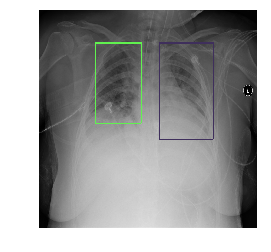

In [6]:
parsed = kgtools.parse_data(df, train_data_dir)
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])
kgtools.draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

### Get the boxes only:

In [57]:
# find the largest, smallest, and average box size
# print(type(parsed), len(parsed))
h_max = 0
w_max = 0
h_min = 1024
w_min = 1024
n_boxes = 0
No_box_samples_count = 0
samples_count = 0
for pt_id, id_dict in parsed.items():
    boxes_list = id_dict['boxes']
    samples_count += 1
    if len(boxes_list) == 0: No_box_samples_count += 1
    for box in boxes_list:
        n_boxes += 1
        h_max = max(h_max, box[2])
        w_max = max(w_max, box[3])
        h_min = min(h_min, box[2])
        w_min = min(w_min, box[3])
        
print(samples_count, 'samples', n_boxes, 'total boxes', No_box_samples_count, 'samples with no box')
print('max height',h_max)
print('max width',w_max)
print('min height',h_min)
print('min width',h_min)

25684 samples 8964 total boxes 20025 samples with no box
max height 942.0
max width 528.0
min height 45.0
min width 45.0


In [74]:
base_name = df['patientId'][0]
print(base_name, type(base_name))

0004cfab-14fd-4e49-80ba-63a80b6bddd6 <class 'str'>


In [34]:

d = pydicom.read_file(parsed['00436515-870c-4b36-a041-de91049b9ab4']['dicom'])
im = d.pixel_array
boxes_list = parsed['00436515-870c-4b36-a041-de91049b9ab4']['boxes']

for box in boxes_list:
    print(box)

# im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

[152.0, 264.0, 379.0, 213.0]
[152.0, 562.0, 453.0, 256.0]
<class 'numpy.ndarray'>
uint8
(1024, 1024)


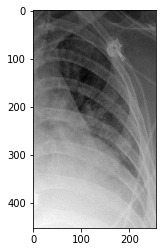

In [44]:
box = boxes_list[1]
sm_im = im[int(box[0]): int(box[0]+box[2]),int(box[1]): int(box[1]+box[3])]
pylab.imshow(sm_im, cmap=pylab.cm.gist_gray)

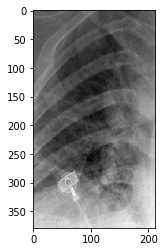

In [43]:
box = boxes_list[0]
sm_im = im[int(box[0]): int(box[0]+box[2]),int(box[1]): int(box[1]+box[3])]
pylab.imshow(sm_im, cmap=pylab.cm.gist_gray)

In [70]:
from PIL import Image

sm_im_tmb = Image.fromarray(sm_im)
scalef = 1/8
size = np.int_(np.array(sm_im.shape) * scalef)
outfile = 'tstim.png'
sm_im_tmb.thumbnail(size, Image.ANTIALIAS)
sm_im_tmb.save(outfile, "png")


In [61]:
scalef = 1/8
np.int_(np.array(sm_im.shape) * scalef)

array([56, 32])

In [67]:
def 

In [71]:
import PIL
PIL.__version__

'5.1.0'

dataframe stage_1_detailed_class_info.csv row 0 of 28989 rows
                               patientId: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
                                   class: No Lung Opacity / Not Normal

Summary of stage_1_detailed_class_info.csv
            No Lung Opacity / Not Normal: 11500
                            Lung Opacity: 8964
                                  Normal: 8525


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


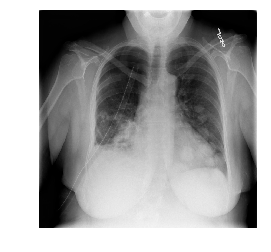

In [32]:
# read the detailed 
detailed_class_info_filename = 'stage_1_detailed_class_info.csv'
df_detailed = pd.read_csv(os.path.join(kaggle_data_dir, 'stage_1_detailed_class_info.csv'))

dataframe_row_number = 0
patientId = df_detailed['patientId'][dataframe_row_number]

summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print('dataframe %s'%(detailed_class_info_filename),
      'row %i'%(dataframe_row_number),
      'of %i rows'%(df_detailed.shape[0]))
selected_df_row = df_detailed.iloc[dataframe_row_number]
for k, v in selected_df_row.items():
    print('%40s: %s'%(k, v))
    
print('\nSummary of %s'%(detailed_class_info_filename))
for k, v in summary.items():
    print('%40s: %s'%(k, v))

kgtools.draw(parsed[patientId])
df_detailed.head()

3

In [80]:
%%writefile ../../src/kaggle_wrangler.py

import os
import glob
import pylab
import pandas as pd
import pydicom
import numpy as np

from PIL import Image

file_ext = '.png'
class_codes_dict = {'No Lung Opacity / Not Normal': 'NoLuOpNotNorm',
                            'Lung Opacity': 'LuOp',
                                  'Normal': 'Normal'}

def get_thumbnail_name(patiendID, class_code, number_of_boxes):
    thumbnail_name = patiendID + '_%i_'%(number_of_boxes) + class_code + file_ext
    return thumbnail_name

def get_class_code(patientID, class_info_df):
    index_list = class_info_df.index[class_info_df['patientId'] == patientID].tolist()
    class_code_key = class_info_df.loc[index_list[0]]['class']
    return class_codes_dict[class_code_key]

def get_boxes(patientID, parsed_data):
    boxes_list = parsed_data[patientID]['boxes']
    boxes_dict = {'number_of_boxes':len(boxes_list)}
    if boxes_dict['number_of_boxes'] > 0:
        box_number = 0
        for box in boxes_list:
            x1 = int(box[0])
            x2 = int(box[0]+box[2])
            y1 = int(box[1])
            y2 = int(box[1]+box[3])
        boxes_dict[box_number] = {'top_row': x1, 'bottom_row': x2, 'left_column': y1, 'right_column': y2}
        box_number += 1
        
    return boxes_dict

# https://www.kaggle.com/peterchang77/exploratory-data-analysis

def parse_data(df, images_dir):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:
      parsed = {
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...
      }
    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': os.path.join(images_dir, '%s.dcm'% pid),
                'label': row['Target'],
                'boxes': []}
        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

def draw(data):
    """ Method to draw single patient with bounding box(es) if present """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """ Method to overlay single box on image """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

Overwriting ../../src/kaggle_wrangler.py
